# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from PIL import Image
from sklearn.model_selection import KFold

Load data

In [19]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')
Xtrain1_extra = Xtrain1_extra.reshape(-1, 48, 48, 1)
print(Xtrain1.shape)

(2783, 2304)


In [20]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    # Reshape the images from (2783, 2304) to (2783, 48, 48)
    reshaped_images = images.reshape(-1, 48, 48)

    for img, label in zip(reshaped_images, labels):
        pil_img = Image.fromarray(img)

        # Original image
        augmented_images.append(np.array(pil_img))
        # Horizontal flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
        # Vertical flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_TOP_BOTTOM)))
        # Rotate 90 degrees
        augmented_images.append(np.array(pil_img.rotate(90)))
        # Rotate 180 degrees
        augmented_images.append(np.array(pil_img.rotate(180)))
        # Rotate 270 degrees
        augmented_images.append(np.array(pil_img.rotate(270)))
        # Zoom in
        zoom_img = pil_img.resize((int(48 * 1.2), int(48 * 1.2))).crop((int(48 * 0.1), int(48 * 0.1), int(48 * 1.1), int(48 * 1.1)))
        augmented_images.append(np.array(zoom_img))

        # Append the label for each augmented image
        augmented_labels.extend([label] * 7)

    # Convert the augmented images back to the (num_images, 2304) format
    augmented_images = np.array(augmented_images).reshape(-1, 48 * 48)
    return augmented_images, augmented_labels

In [21]:
# Function to plot images
def plot_images(images, labels, num_images=20, extra=0):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap='gray')
        if extra:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

Compute SMOTE (Synthetic Minority Over-sampling Technique) to deal with the low quantity of crater data

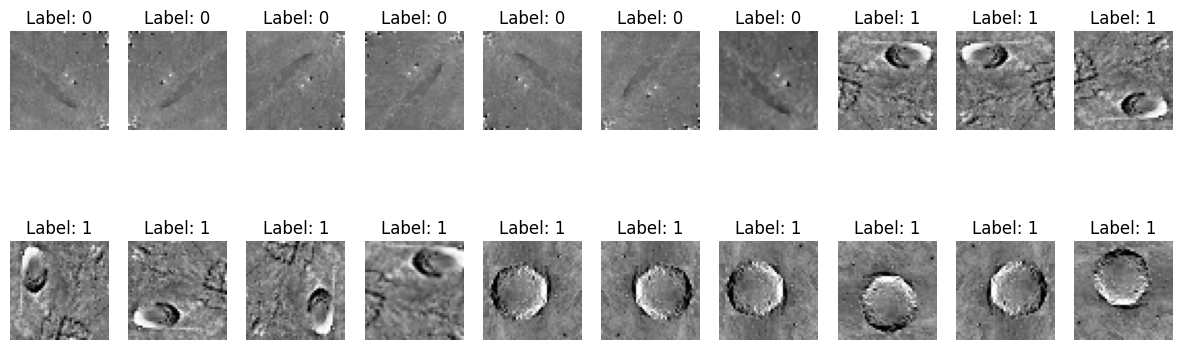

In [22]:
smote = SMOTE()

Xtrain_resampled, Ytrain_resampled = smote.fit_resample(Xtrain1, Ytrain1)

Xtrain_resampled, Ytrain_resampled = augment_images(Xtrain_resampled, Ytrain_resampled)

Xtrain_resampled = Xtrain_resampled.reshape(-1, 48, 48, 1)

Ytrain_cat = to_categorical(Ytrain_resampled, 2)

plot_images(Xtrain_resampled, Ytrain_resampled, extra=1)

## Build CNNs

### CNN

In [23]:
# Build a simple CNN model
def build_model_CNN():
    model_CNN = Sequential([
        Input(shape=(48, 48, 1)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5), # model summary
        Dense(2, activation='softmax')
    ])
    # Compile the model
    model_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model_CNN

## Train the models

Callbacks

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5)

### CNN

In [28]:
# Function to train the model using cross-validation
def model_cross_validation(X, Y, n_splits=5, epochs=50, batch_size=32):
    kf = KFold(n_splits=n_splits)
    best_f1 = 0

    for train_index, val_index in kf.split(X):
        print(f"Training fold")
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = Y[train_index], Y[val_index]

        model = build_model_CNN()

        model.fit(X_train_fold, y_train_fold, epochs=epochs, batch_size=batch_size, verbose=1,
                  validation_data=(X_val_fold, y_val_fold),
                  callbacks=[early_stopping, reduce_lr])
        
        y_pred = model.predict(X_val_fold)
        y_pred = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_val_fold, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            model.save('best_model.keras')

## Evaluation of the models

### CNN

In [29]:
model_cross_validation(Xtrain_resampled, Ytrain_cat, n_splits=5, epochs=50, batch_size=32)
# Load the best model
best_model = load_model('best_model.keras')

Training fold
Epoch 1/50
151/622 ━━━━━━━━━━━━━━━━━━━━ 25s 54ms/step - accuracy: 0.7790 - loss: 0.5281

KeyboardInterrupt: 

### Final predictions

In [ ]:
Xtest1 = Xtest1.reshape(-1, 48, 48, 1)
predY_final = best_model.predict(Xtest1)
predY_classes_final = np.argmax(predY_final, axis=1)

# Save the predictions with np
np.save('predY_classes_final.npy', predY_classes_final)